In [1]:
import numpy as np

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

np.random.seed(123)
torch.manual_seed(123)

# Use some real data - river-dl

In [2]:
# data from Simon's ~June 2022 river-dl run
river_dl = np.load("../../../Downloads/prepped_365_1.npz", allow_pickle = True)

# Subsetting data to
#    last year of data, (last batch of 455)
#    180-day sequences (second half of the water? year)
#    first 7 input vars (redundant now)
x = torch.from_numpy(river_dl['x_trn']).float()[-455:, -180:, :7]
y = torch.from_numpy(river_dl['y_obs_trn']).float()[-455:, -180:]

adj_matrix = river_dl['dist_matrix']
batch_size = adj_matrix.shape[0]

x.shape, y.shape, adj_matrix.shape

(torch.Size([455, 180, 7]), torch.Size([455, 180, 1]), (455, 455))

# Define RGCN v1

In [3]:
## RGCN - This version follows the published version of the RGCN by Jia et al. (2020)
# https://doi.org/10.1137/1.9781611976700.69
class RGCN_v1(nn.Module):
    # Built off of https://towardsdatascience.com/building-a-lstm-by-hand-on-pytorch-59c02a4ec091
    def __init__(self, input_dim, hidden_dim, adj_matrix, recur_dropout=0, dropout=0, return_states=False, device='cpu'):
        """
        @param input_dim: [int] number input feature
        @param hidden_dim: [int] hidden size
        @param adj_matrix: Distance matrix for graph convolution
        @param recur_dropout: [float] fraction of the units to drop from the cell update vector. See: https://arxiv.org/abs/1603.05118
        @param dropout: [float] fraction of the units to drop from the input
        @param return_states: [bool] If true, returns h and c states as well as predictions
        """
        super().__init__()

        # New stuff
        self.A = torch.from_numpy(adj_matrix).float().to(device)  # provided at initialization
        # parameters for mapping graph/spatial data
        self.weight_q = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.bias_q = nn.Parameter(torch.Tensor(hidden_dim))

        self.input_dim = input_dim
        self.hidden_size = hidden_dim
        self.weight_ih = nn.Parameter(torch.Tensor(input_dim, hidden_dim * 4))
        self.weight_hh = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_dim * 4))
        self.init_weights()

        self.dropout = nn.Dropout(dropout)
        self.recur_dropout = nn.Dropout(recur_dropout)

        self.dense = nn.Linear(hidden_dim, 1)
        self.return_states = return_states

    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)

    def forward(self, x, init_states=None):
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device),
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states

        x = self.dropout(x)
        HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.weight_ih + h_t @ self.weight_hh + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]),  # input
                torch.sigmoid(gates[:, HS:HS * 2]),  # forget
                torch.tanh(gates[:, HS * 2:HS * 3]),
                torch.sigmoid(gates[:, HS * 3:]),  # output
            )
            q_t = torch.tanh(h_t @ self.weight_q + self.bias_q)
            c_t = f_t * (c_t + self.A @ q_t) + i_t * self.recur_dropout(g_t)  # note: self.A @ q_t
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(1))
        hidden_seq = torch.cat(hidden_seq, dim=1)
        out = self.dense(hidden_seq)
        if self.return_states:
            return out, (h_t, c_t)
        else:
            return out
        
def rmse_masked(y_true, y_pred):
    num_y_true = torch.count_nonzero(~torch.isnan(y_true))
    if num_y_true > 0:
        zero_or_error = torch.where(
            torch.isnan(y_true), torch.zeros_like(y_true), y_pred - y_true
        )
        sum_squared_errors = torch.sum(torch.square(zero_or_error))
        rmse_loss = torch.sqrt(sum_squared_errors / num_y_true)
    else:
        rmse_loss = 0.0
    return rmse_loss

In [4]:
model = RGCN_v1(7, 20, adj_matrix)

In [5]:
loss_fn = rmse_masked
optimizer = torch.optim.Adam(model.parameters())

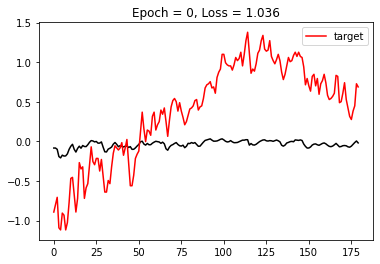

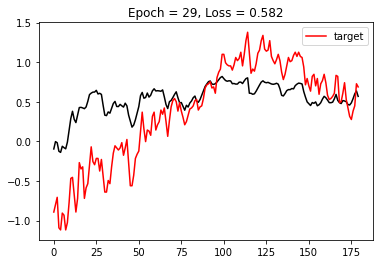

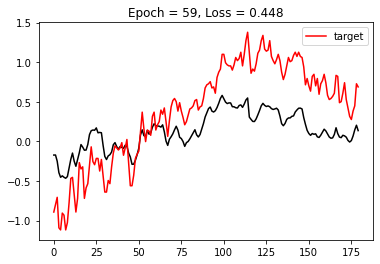

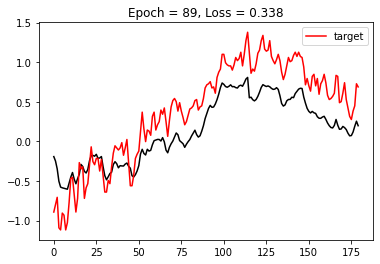

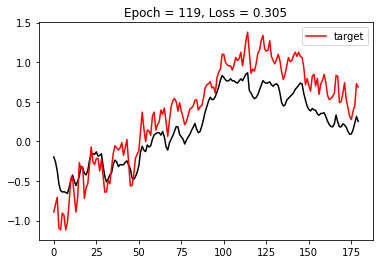

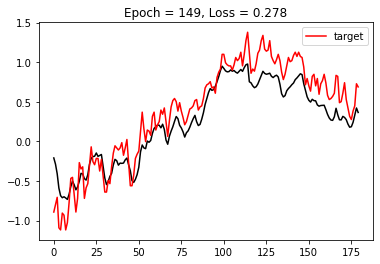

In [6]:
epochs = 150

for i in range(epochs):
    out = model(x)
    loss = loss_fn(y, out)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % int(epochs/5) == 0 or i == 0:
        plt.plot(out.detach()[1], color = 'black')
        plt.plot(y[-455:][1], color = 'red', label = 'target')
        plt.title('Epoch = ' + str(i) + ', Loss = ' + str(np.round(loss.item(), 3)))
        plt.legend()
        plt.pause(0.001);

# Identify an extreme

In [7]:
np.argwhere(y.detach().numpy() == np.nanmax(y.detach().numpy()))

array([[438, 108,   0]], dtype=int64)

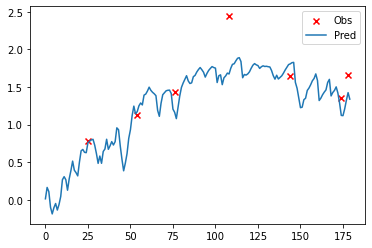

In [8]:
plt.scatter(range(180), y[438, :].detach(), color = 'red', marker = 'x', label = "Obs")
plt.plot(out[438, :].detach(), label = 'Pred')
plt.legend();

# Backwards optimization

In [9]:
# loss is 3x higher for this extreme
loss_fn(y, out), loss_fn(y[438, 108], out[438, 108])

(tensor(0.2779, grad_fn=<SqrtBackward0>),
 tensor(0.7676, grad_fn=<SqrtBackward0>))

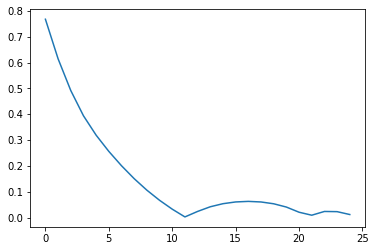

In [10]:
optimal_input = x.clone()
optimal_input.requires_grad = True
optimizer = torch.optim.Adam([optimal_input], lr = 0.1)

loss_ls = []
for i in range(25):
    
    optimal_output = model(optimal_input)
    loss = loss_fn(y[438, 108], optimal_output[438, 108])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_ls.append(loss.item())
    
plt.plot(loss_ls)

### How the optimal input performs

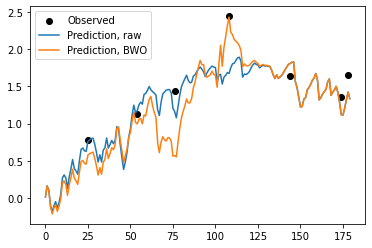

In [11]:
plt.scatter(range(180), y[438].detach(), color = 'black', label = 'Observed')

natural_out = model(x)
plt.plot(natural_out[438].detach(), label = 'Prediction, raw')

optimal_out = model(optimal_input)
plt.plot(optimal_output[438].detach(), label = 'Prediction, BWO')
plt.legend(loc = 'upper left');

### How does the optimal input differ?

Note some undesirable behavior of inducing static variables to be dynamic. We can no-doubt constrain that with more effort.

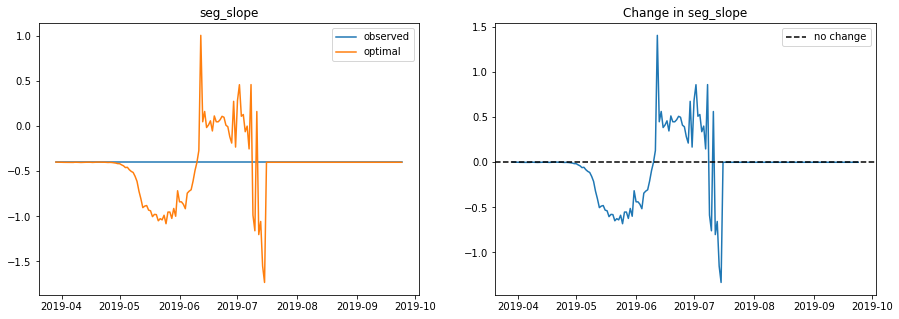

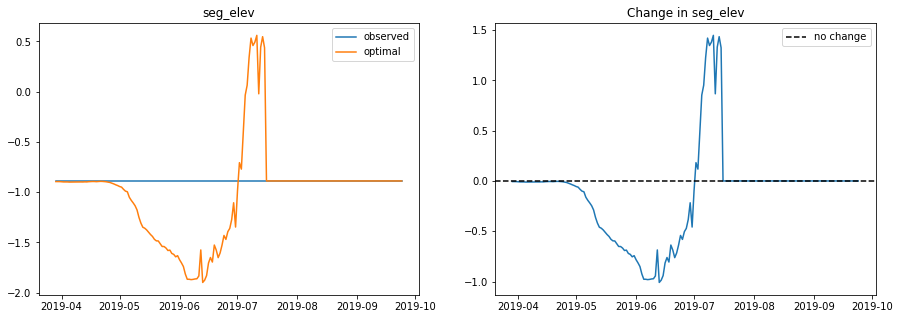

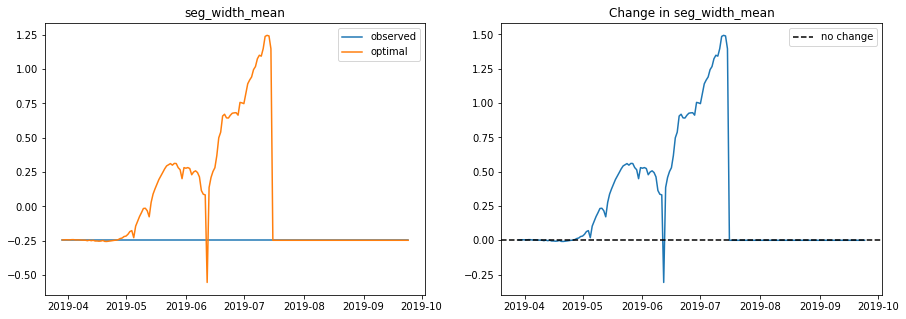

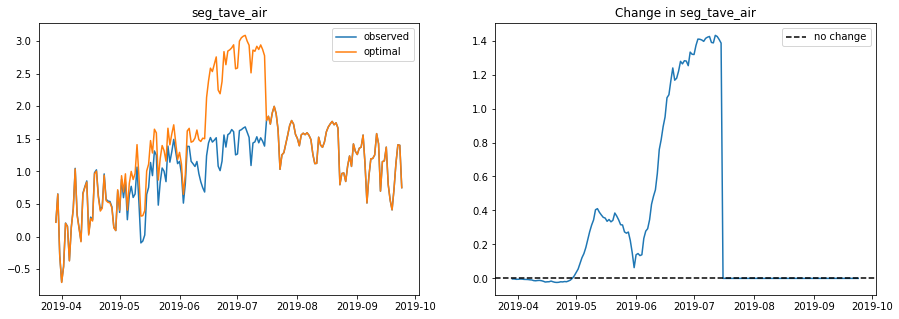

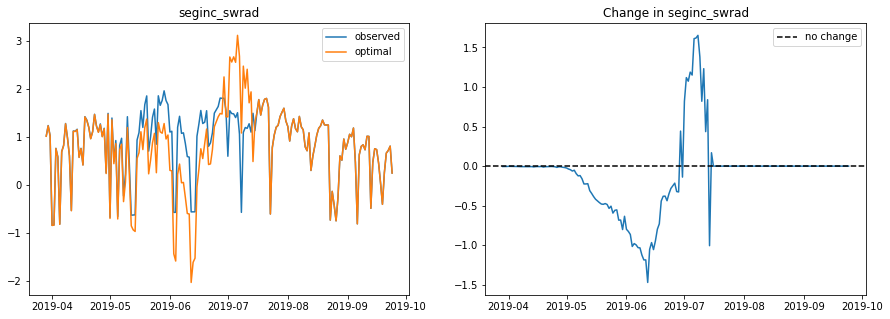

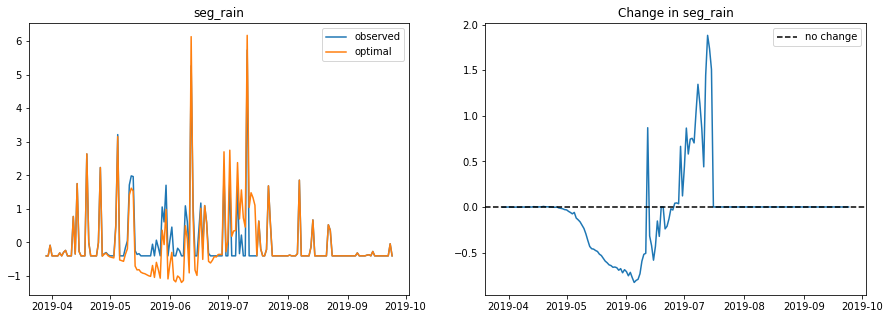

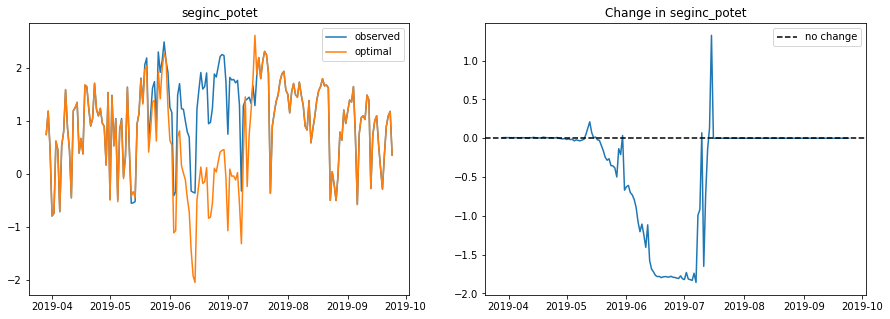

In [12]:
for i in range(7):
    fig, ax = plt.subplots(1, 2, figsize = (15, 5))
    
    ax[0].plot(river_dl['times_trn'][-455:, -180:, 0][438], x[438, :, i].detach(), label = 'observed')
    ax[0].plot(river_dl['times_trn'][-455:, -180:, 0][438], optimal_input[438, :, i].detach(), label = 'optimal')
    ax[0].legend()
    ax[0].set_title(river_dl['x_vars'][i])
    
    ax[1].plot(river_dl['times_trn'][-455:, -180:, 0][438],
               optimal_input[438, :, i].detach() - x[438, :, i].detach())
    ax[1].axhline(0, color = 'black', linestyle = '--', label = 'no change')
    ax[1].legend()
    ax[1].set_title('Change in ' + river_dl['x_vars'][i])
    
    plt.pause(0.00001)

# Feature importance of the original and optimal input

In [13]:
def expected_gradients(x, y, x_set, adj_matrix, model, n_samples, temporal_focus=None, spatial_focus=None):

    n_series = x_set.shape[0]
    n_segs = adj_matrix.shape[0]
    num_vars = x_set.shape[2]
    seq_len = x_set.shape[1]

    x_set_4D = x_set.reshape(n_series//n_segs,n_segs,seq_len,num_vars)

    for k in range(n_samples):
        # SAMPLE A RANDOM BASELINE INPUT/YEAR
        rand_year = np.random.choice(n_series//n_segs)
        baseline_x = x_set_4D[rand_year]

        # SAMPLE A RANDOM SCALE ALONG THE DIFFERENCE
        scale = np.random.uniform()

        # SAME IG CALCULATION
        x_diff = x - baseline_x
        curr_x = baseline_x + scale*x_diff
        if curr_x.requires_grad == False:
            curr_x.requires_grad = True
        model.zero_grad()
        y = model(curr_x)

        # GET GRADIENT
        if temporal_focus == None and spatial_focus == None:
            gradients = torch.autograd.grad(y[:, :, :], curr_x, torch.ones_like(y[:, :, :]))
        elif temporal_focus == None and spatial_focus != None:
            gradients = torch.autograd.grad(y[spatial_focus, :, :], curr_x, torch.ones_like(y[spatial_focus, :, :]))
        elif temporal_focus != None and spatial_focus == None:
            gradients = torch.autograd.grad(y[:, temporal_focus, :], curr_x, torch.ones_like(y[:, temporal_focus, :]))
        else:
            gradients = torch.autograd.grad(y[spatial_focus, temporal_focus, :], curr_x, torch.ones_like(y[spatial_focus, temporal_focus, :]))

        if k == 0:
            expected_gradients = x_diff*gradients[0] * 1/k
        else:
            expected_gradients = expected_gradients + ((x_diff*gradients[0]) * 1/n_samples)
    return(expected_gradients)

### The original

seg_slope 
	 0.0
seg_elev 
	 0.0
seg_width_mean 
	 0.0
seg_tave_air 
	 0.04926736
seginc_swrad 
	 0.021647159
seg_rain 
	 0.021656867
seginc_potet 
	 0.031558372


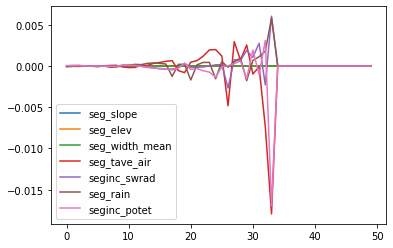

In [14]:
# some value setting
x = torch.from_numpy(river_dl['x_trn']).float()[:, -180:, :7]
K = 200 # EG steps

# calculate attribution
EG_vals = expected_gradients(x[-455:, -180:], y[-455:, -180:], x[:, -180:, :7], adj_matrix, model,
                             200, temporal_focus=108, spatial_focus=438)

# plot attribution around the extreme space-time
for i in range(7):
    plt.plot(EG_vals[438, 75:125, i].detach(), label = river_dl['x_vars'][i])
plt.legend();

# print aggregate measures of attribution
for i in range(7):
    print(river_dl['x_vars'][i], '\n\t', np.sum(np.abs(EG_vals[438].detach().numpy()), axis = 0)[i])

### The optimal

In [15]:
EG_vals = expected_gradients(optimal_input, y[-455:, -180:], x[:, -180:, :7], adj_matrix, model,
                             200, temporal_focus=108, spatial_focus=438)

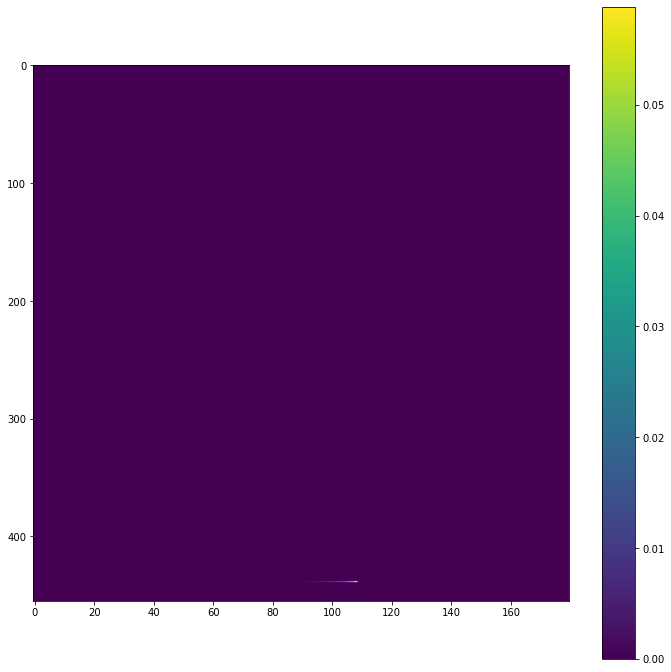

In [16]:
# the optimal input is most concerned with same-segment changes
plt.figure(figsize = (12, 12))
plt.imshow(EG_vals[:, :, 3].detach().numpy(), aspect = 180/455)
plt.colorbar()

seg_slope 
	 0.09982258
seg_elev 
	 0.0448824
seg_width_mean 
	 0.16155761
seg_tave_air 
	 0.26417774
seginc_swrad 
	 0.026626784
seg_rain 
	 0.049572475
seginc_potet 
	 0.048928015


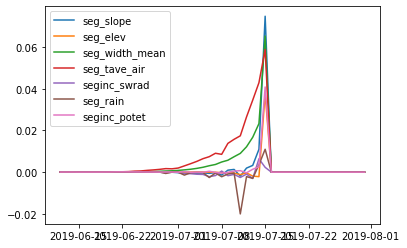

In [17]:
for i in range(7):
    plt.plot(river_dl['times_trn'][-455:, -180:, 0][438, 75:125],
             EG_vals[438, 75:125, i].detach(), label = river_dl['x_vars'][i])
plt.legend();

# air temp is the most important, but it also tries to strongly change
# static attributes such as slope and width
for i in range(7):
    print(river_dl['x_vars'][i], '\n\t', np.sum(np.abs(EG_vals[438].detach().numpy()), axis = 0)[i])

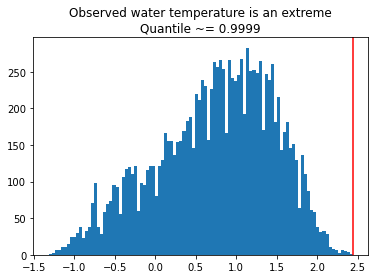

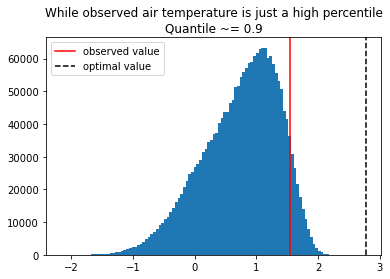

In [18]:
plt.hist(y.detach().numpy().flatten(), bins = 100)
plt.axvline(y[438, 108, 0].detach().item(), color = 'red')
plt.title('Observed water temperature is an extreme\nQuantile ~= 0.9999')
plt.pause(0.001)

plt.title('While observed air temperature is just a high percentile\nQuantile ~= 0.9')
plt.hist(x[:, :, 3].detach().numpy().flatten(), bins = 100)
plt.axvline(x[438, 108, 3].detach().item(), color = 'red',
            label = 'observed value')
plt.axvline(optimal_input[438, 108, 3].detach().item(), color = 'black',
            linestyle = '--', label = 'optimal value')
plt.legend();

In [19]:
print(np.nanquantile(y.detach().numpy().flatten(), 0.9999),
      np.nanquantile(x[:, :, 3].detach().numpy().flatten(), 0.9))

2.401322364807129 1.4832018613815308


In this extreme case, the variables seem underspecified for contextualizing extreme heat and the primary way the model could predict higher would be to severely inflate air temperature (which is mechanistically sound) or unrealistically play with static attributes.

# We can constrain the optimal input further

It's not perfect, but it's a concept demonstration... Leads to large the same interpretation. The model most obviously wants to see a lot of higher air temperatures and play around with static values.

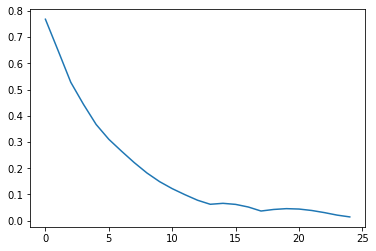

In [20]:
optimal_input = x[-455:, -180:, :].clone()
optimal_input.requires_grad = True
optimizer = torch.optim.Adam([optimal_input], lr = 0.1)

loss_ls = []
for i in range(25):
    
    optimal_output = model(optimal_input)
    loss = (loss_fn(y[438, 108], optimal_output[438, 108]) +
            # penalize static variables for varying
            5*torch.var(optimal_input[438, :, 0]) +
            5*torch.var(optimal_input[438, :, 1]) +
            5*torch.var(optimal_input[438, :, 2]))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_ls.append(loss.item())
    
plt.plot(loss_ls)

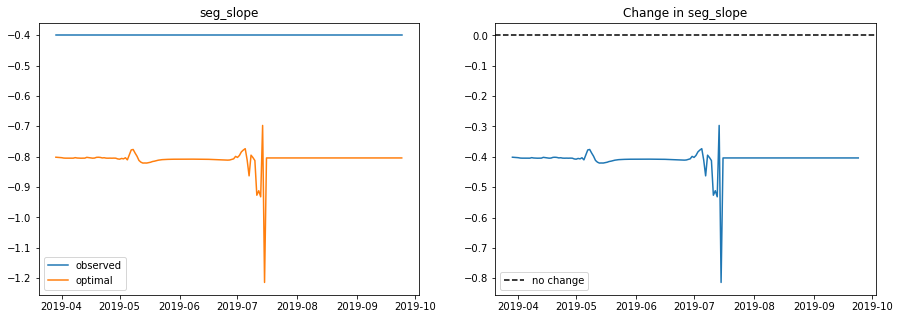

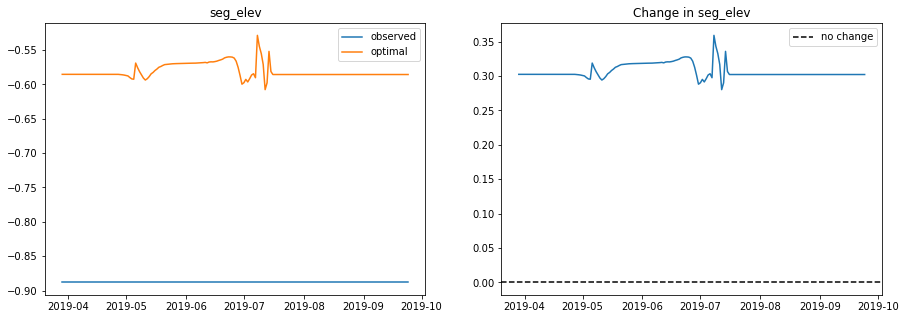

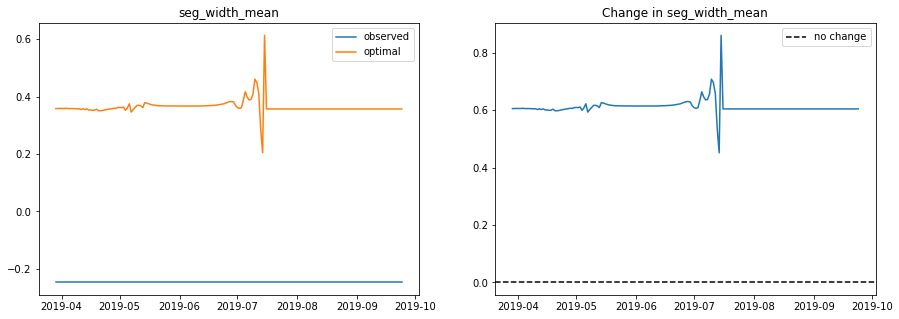

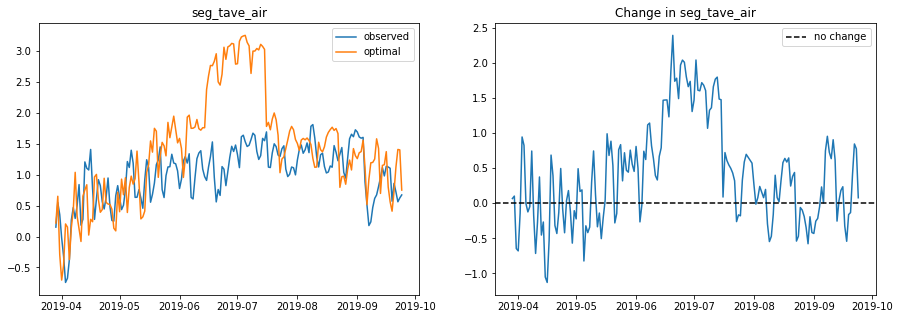

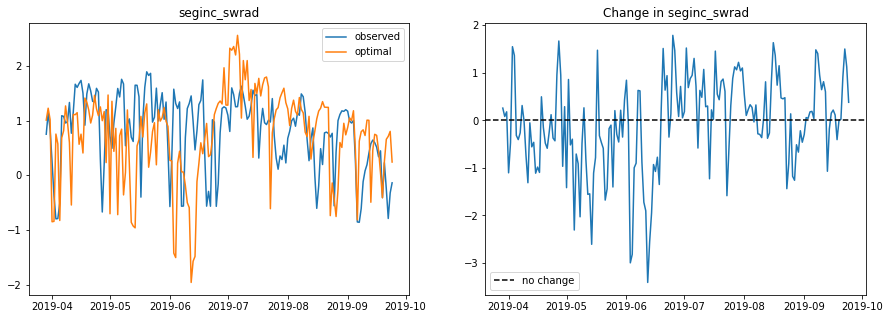

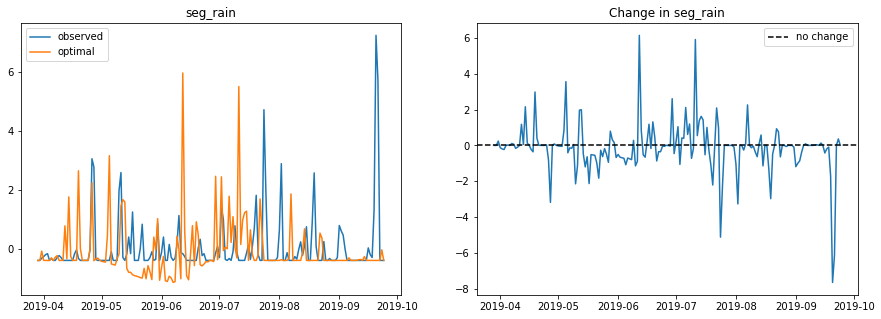

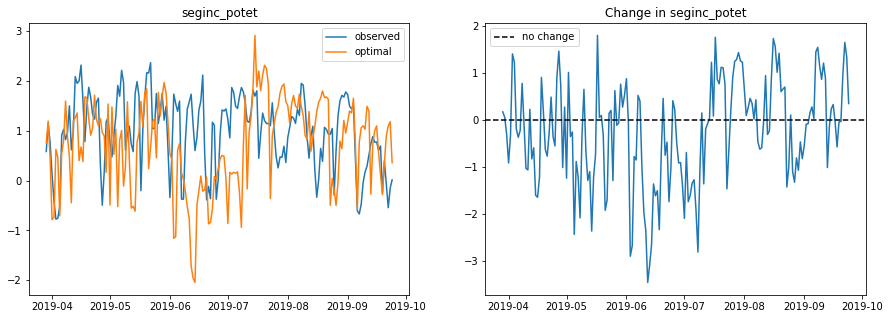

In [21]:
for i in range(7):
    fig, ax = plt.subplots(1, 2, figsize = (15, 5))
    
    ax[0].plot(river_dl['times_trn'][-455:, -180:, 0][438], x[438, :, i].detach(), label = 'observed')
    ax[0].plot(river_dl['times_trn'][-455:, -180:, 0][438], optimal_input[438, :, i].detach(), label = 'optimal')
    ax[0].legend()
    ax[0].set_title(river_dl['x_vars'][i])
    
    ax[1].plot(river_dl['times_trn'][-455:, -180:, 0][438],
               optimal_input[438, :, i].detach() - x[438, :, i].detach())
    ax[1].axhline(0, color = 'black', linestyle = '--', label = 'no change')
    ax[1].legend()
    ax[1].set_title('Change in ' + river_dl['x_vars'][i])
    
    plt.pause(0.00001)

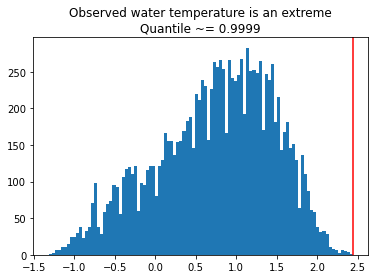

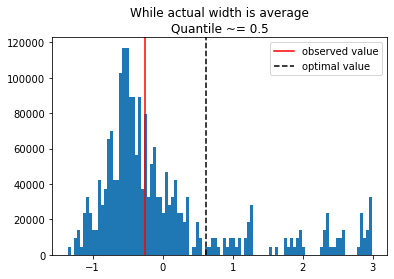

In [22]:
plt.hist(y.detach().numpy().flatten(), bins = 100)
plt.axvline(y[438, 108, 0].detach().item(), color = 'red')
plt.title('Observed water temperature is an extreme\nQuantile ~= 0.9999')
plt.pause(0.001)

plt.title('While actual width is average\nQuantile ~= 0.5')
plt.hist(x[:, :, 2].detach().numpy().flatten(), bins = 100)
plt.axvline(x[438, 108, 2].detach().item(), color = 'red',
            label = 'observed value')
plt.axvline(optimal_input[438, 108, 2].detach().item(), color = 'black',
            linestyle = '--', label = 'optimal value')
plt.legend();

Previous EG results showed that air temperature and width were the two most important features in the optimal input. Here, even when penalizing width for not being static, the model would like to see an increasingly wide river that also has a growing thermal inertia (lots of increased preceding air temperature) in order to predict the extreme air temperature that was observed. In other words, from what the model has learned, the river was too narrow and not previously warmed enough to be as hot as it was. 

Additionally, the next most important variable was slope (with the optimal input having lower slope), so with these three combined - the model would've predicted such an extreme temperature for a lower-slope, wider river that had experienced more prior warming. Thus, one might decide this is entirely reasonable and therefore a good model (or at least not overly spurious), but that it is still missing something - whether that be representative historical data (of an extreme happening under these conditions) or additional variables (that would better portray this extreme).